# Advanced Political Sentiment Analysis Using Large Language Models (LLMs)

This notebook demonstrates an advanced approach to performing sentiment analysis on political tweets using Large Language Models (LLMs). By leveraging Hugging Face's `transformers` library, we utilize state-of-the-art pre-trained models to classify sentiments expressed in tweets related to various political candidates and parties. The analysis encompasses data loading, cleaning, exploratory data analysis, preprocessing, model inference, and evaluation.

## Table of Contents
1. [Introduction](#Introduction)
2. [Environment Setup](#Environment-Setup)
3. [Data Loading](#Data-Loading)
4. [Data Exploration](#Data-Exploration)
    - [Dataset Overview](#Dataset-Overview)
    - [Sentiment Distribution](#Sentiment-Distribution)
    - [Sentiment by Political Party](#Sentiment-by-Political-Party)
    - [Tweet Length Analysis](#Tweet-Length-Analysis)
    - [Temporal Sentiment Trends](#Temporal-Sentiment-Trends)
    - [Word Clouds](#Word-Clouds)
5. [Data Preprocessing](#Data-Preprocessing)
    - [Text Cleaning](#Text-Cleaning)
    - [Handling Missing Values](#Handling-Missing-Values)
    - [Encoding Categorical Variables](#Encoding-Categorical-Variables)
6. [LLM-Based Sentiment Analysis](#LLM-Based-Sentiment-Analysis)
    - [Model Selection](#Model-Selection)
    - [Inference with Pre-trained Models](#Inference-with-Pre-trained-Models)
7. [Evaluation](#Evaluation)
    - [Performance Metrics](#Performance-Metrics)
    - [Confusion Matrix](#Confusion-Matrix)
    - [ROC Curve](#ROC-Curve)
8. [Visualization of Results](#Visualization-of-Results)
9. [Conclusion](#Conclusion)
10. [Future Work](#Future-Work)
11. [References](#References)
12. [Acknowledgments](#Acknowledgments)

## Introduction

In the age of social media, platforms like X (formerly Twitter) serve as significant channels for political discourse. Analyzing the sentiments expressed in political tweets provides valuable insights into public opinion, enabling political analysts, campaigners, and stakeholders to gauge the effectiveness of campaigns, public reception of policies, and overall political climate. This notebook employs Large Language Models (LLMs) to perform a nuanced sentiment analysis of political tweets, offering a sophisticated approach compared to traditional machine learning techniques.

## Environment Setup

In [ ]:
# Install necessary libraries
!pip install transformers torch seaborn wordcloud

## Data Loading

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from transformers import pipeline
import torch
import re
import warnings
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
# Load datasets
train = pd.read_csv('/content/drive/MyDrive/2024_US_PE_Sentiment_train.csv')
test = pd.read_csv('/content/drive/MyDrive/2024_US_PE_Sentiment_test.csv')
val = pd.read_csv('/content/drive/MyDrive/2024_US_PE_sentiment_val.csv')


In [ ]:
# Display the first few rows of each dataset
print('Train Dataset:\n', train.head())
print('\nTest Dataset:\n', test.head())
print('\nValidation Dataset:\n', val.head())

Train Dataset:
    tweet_id     user_handle            timestamp  \
0         1        @user123  2024-11-03 08:45:00   
1         2    @politicsFan  2024-11-03 09:15:23   
2         3  @greenAdvocate  2024-11-03 10:05:45   
3         4     @indieVoice  2024-11-03 11:20:10   
4         5   @libertyLover  2024-11-03 12:35:55   

                                          tweet_text       candidate  \
0  Excited to see Kamala Harris leading the Democ...   Kamala Harris   
1  Donald Trump's policies are the best for our e...    Donald Trump   
2  Jill Stein's environmental plans are exactly w...      Jill Stein   
3  Robert Kennedy offers a fresh perspective outs...  Robert Kennedy   
4  Chase Oliver's libertarian stance promotes tru...    Chase Oliver   

               party  retweets  likes sentiment  
0   Democratic Party       120    450  positive  
1   Republican Party        85    300  positive  
2        Green Party        60    200  positive  
3        Independent        40    150 

## Data Exploration

### Dataset Overview

In [ ]:
# Summary statistics of train dataset
print('Train Dataset Info:')
train.info()

# Summary statistics of test dataset
print('\nTest Dataset Info:')
test.info()

# Summary statistics of validation dataset
print('\nValidation Dataset Info:')
val.info()

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     500 non-null    int64 
 1   user_handle  500 non-null    object
 2   timestamp    500 non-null    object
 3   tweet_text   500 non-null    object
 4   candidate    500 non-null    object
 5   party        500 non-null    object
 6   retweets     500 non-null    int64 
 7   likes        500 non-null    int64 
 8   sentiment    500 non-null    object
dtypes: int64(3), object(6)
memory usage: 35.3+ KB

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     50 non-null     int64 
 1   user_handle  50 non-null     object
 2   timestamp    50 non-null     object
 3   tweet_text   50 non-null     object
 4   c

In [ ]:
# Check for duplicate entries
print('\nDuplicate entries in Train:', train.duplicated().sum())
print('Duplicate entries in Test:', test.duplicated().sum())
print('Duplicate entries in Validation:', val.duplicated().sum())

# Describe numerical features
print('\nNumerical Features Summary:')
print(train.describe())


Duplicate entries in Train: 0
Duplicate entries in Test: 0
Duplicate entries in Validation: 0

Numerical Features Summary:
         tweet_id    retweets       likes
count  500.000000  500.000000  500.000000
mean   250.500000   64.236000  248.920000
std    144.481833   27.715349  120.562034
min      1.000000   18.000000   85.000000
25%    125.750000   40.000000  150.000000
50%    250.500000   70.000000  225.000000
75%    375.250000   90.000000  340.000000
max    500.000000  120.000000  500.000000


### Sentiment Distribution

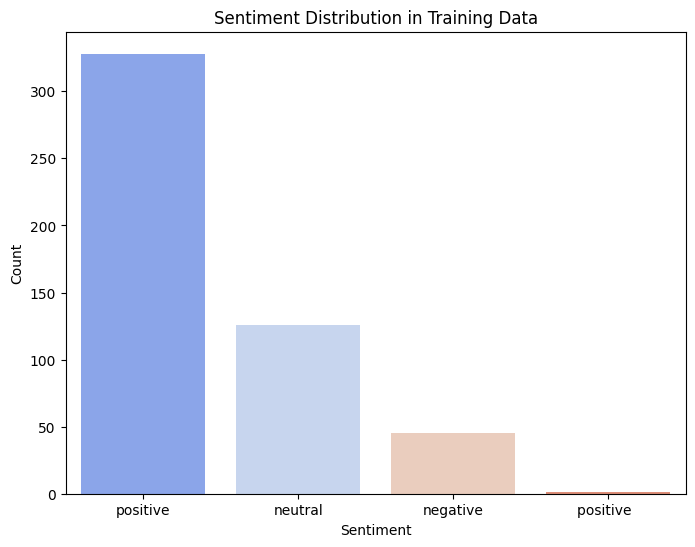

In [ ]:
# Sentiment distribution in train data
plt.figure(figsize=(8,6))
sns.countplot(x='sentiment', data=train, palette='coolwarm')
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### Sentiment by Political Party

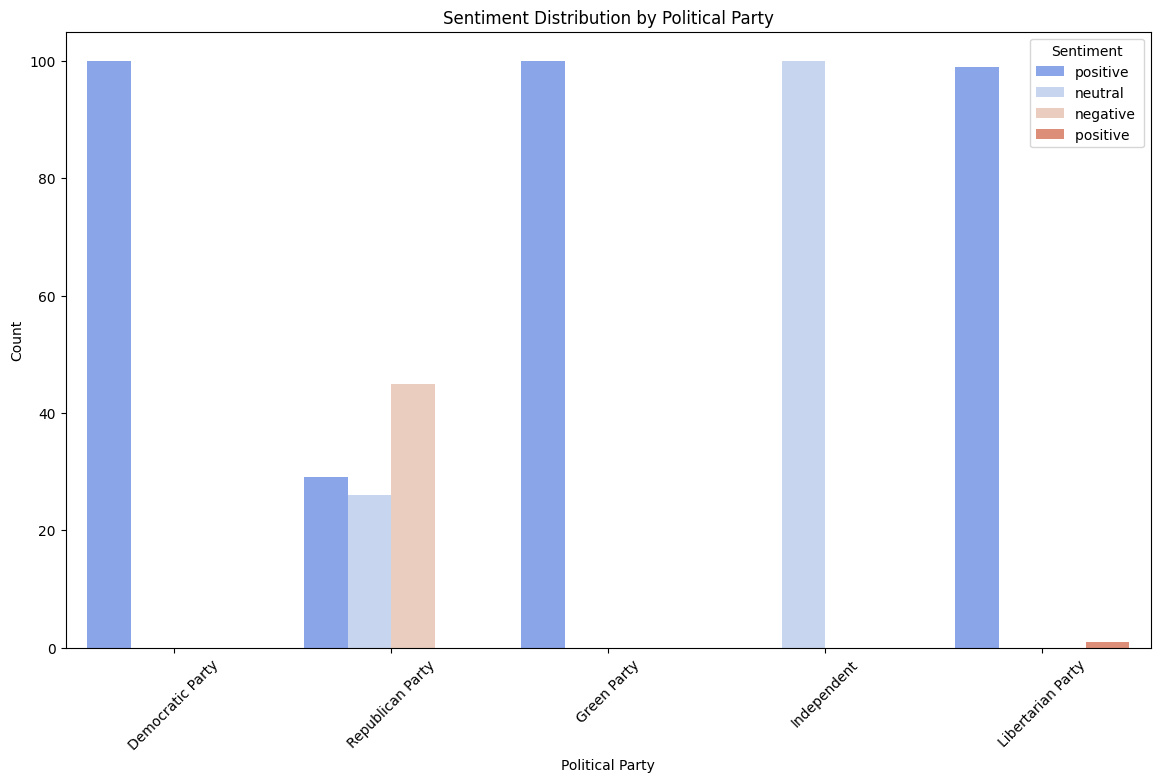

In [ ]:
# Sentiment distribution across parties
plt.figure(figsize=(14,8))
sns.countplot(x='party', hue='sentiment', data=train, palette='coolwarm')
plt.title('Sentiment Distribution by Political Party')
plt.xlabel('Political Party')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

### Tweet Length Analysis

In [ ]:
# Add a new column for tweet length
train['tweet_length'] = train['tweet_text'].apply(lambda x: len(x.split()))
test['tweet_length'] = test['tweet_text'].apply(lambda x: len(x.split()))
val['tweet_length'] = val['tweet_text'].apply(lambda x: len(x.split()))

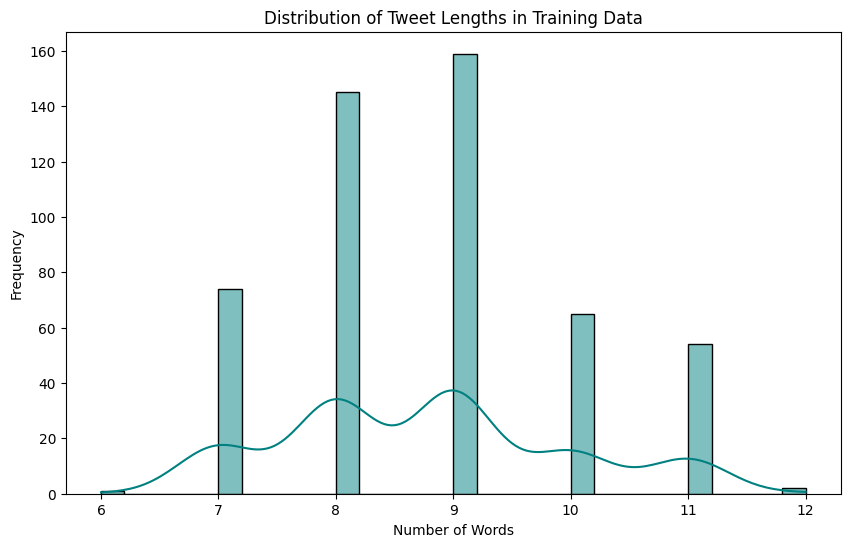

In [ ]:
# Plot distribution of tweet lengths
plt.figure(figsize=(10,6))
sns.histplot(train['tweet_length'], bins=30, kde=True, color='teal')
plt.title('Distribution of Tweet Lengths in Training Data')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

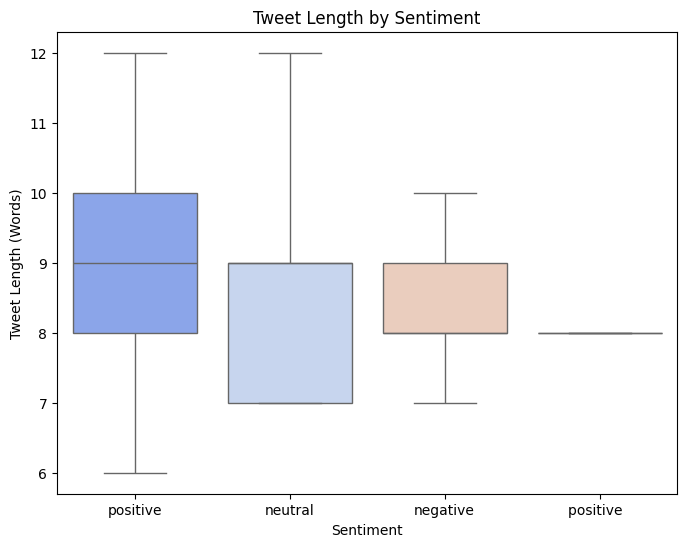

In [ ]:
# Boxplot of tweet length by sentiment
plt.figure(figsize=(8,6))
sns.boxplot(x='sentiment', y='tweet_length', data=train, palette='coolwarm')
plt.title('Tweet Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Length (Words)')
plt.show()

### Temporal Sentiment Trends

In [ ]:
# Convert timestamp to datetime
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])
val['timestamp'] = pd.to_datetime(val['timestamp'])

In [ ]:
# Set timestamp as index for train data
train.set_index('timestamp', inplace=True)

In [ ]:
# Resample to weekly frequency and count sentiments
weekly_sentiment = train.groupby([pd.Grouper(freq='W'), 'sentiment']).size().unstack().fillna(0)

<Figure size 1600x800 with 0 Axes>

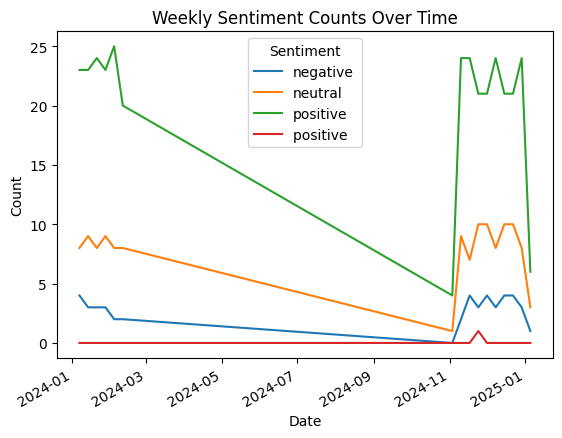

In [ ]:
# Plot time series of sentiments
plt.figure(figsize=(16, 8))
weekly_sentiment.plot()
plt.title('Weekly Sentiment Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

In [ ]:
train['sentiment'].value_counts()

,count
sentiment,
positive,328
neutral,126
negative,45
positive,1


In [ ]:
# Replace values in the 'sentiment' column

train['sentiment'] = train['sentiment'].replace({
   'positive	': 'Positive',
   'neutral': 'Neutral',
   'negative': 'Negative',
   'positive': 'Positive'
})


In [ ]:
test['sentiment'].value_counts()

,count
sentiment,
positive,34
neutral,13
negative,3


In [ ]:
# Replace values in the 'sentiment' column

test['sentiment'] = test['sentiment'].replace({
   'positive': 'Positive',
   'neutral': 'Neutral',
   'negative': 'Negative',
})


In [ ]:
val['sentiment'].value_counts()

,count
sentiment,
positive,34
neutral,13
negative,3


In [ ]:
# Replace values in the 'sentiment' column

val['sentiment'] = val['sentiment'].replace({
   'positive': 'Positive',
   'neutral': 'Neutral',
   'negative': 'Negative',
})


In [ ]:
# remove space from columns in train
train.columns = train.columns.str.strip()

In [ ]:
train['sentiment'].value_counts()

,count
sentiment,
Positive,328
Neutral,126
Negative,45
positive,1


### Word Clouds

In [ ]:
# Function to generate word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(' '.join(text))
    plt.figure(figsize=(15,7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()


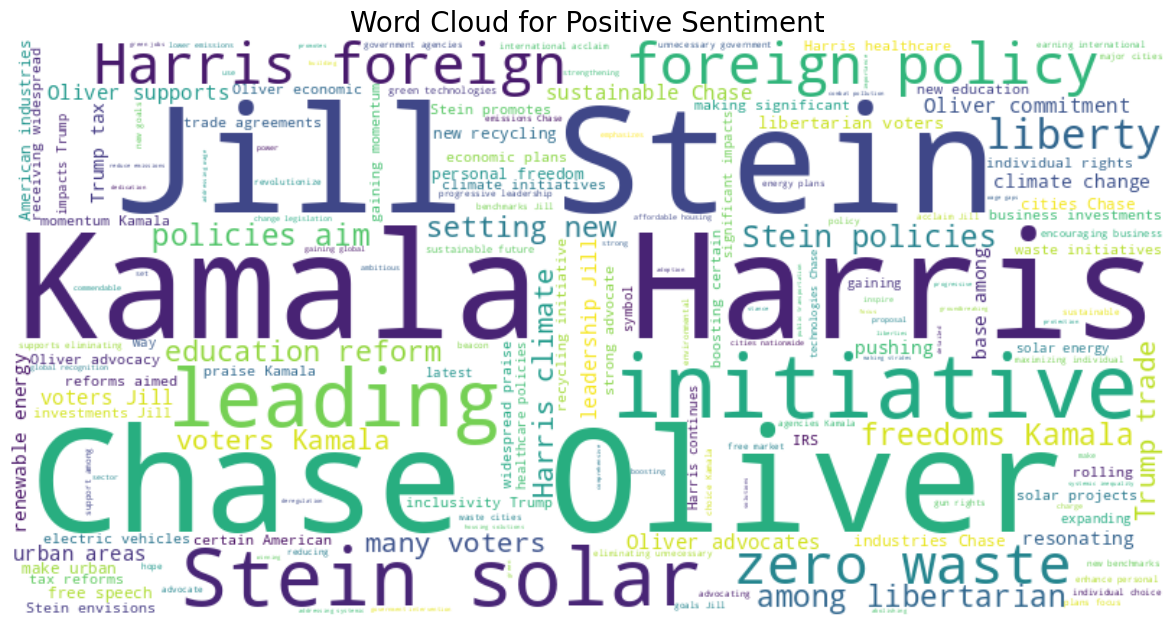

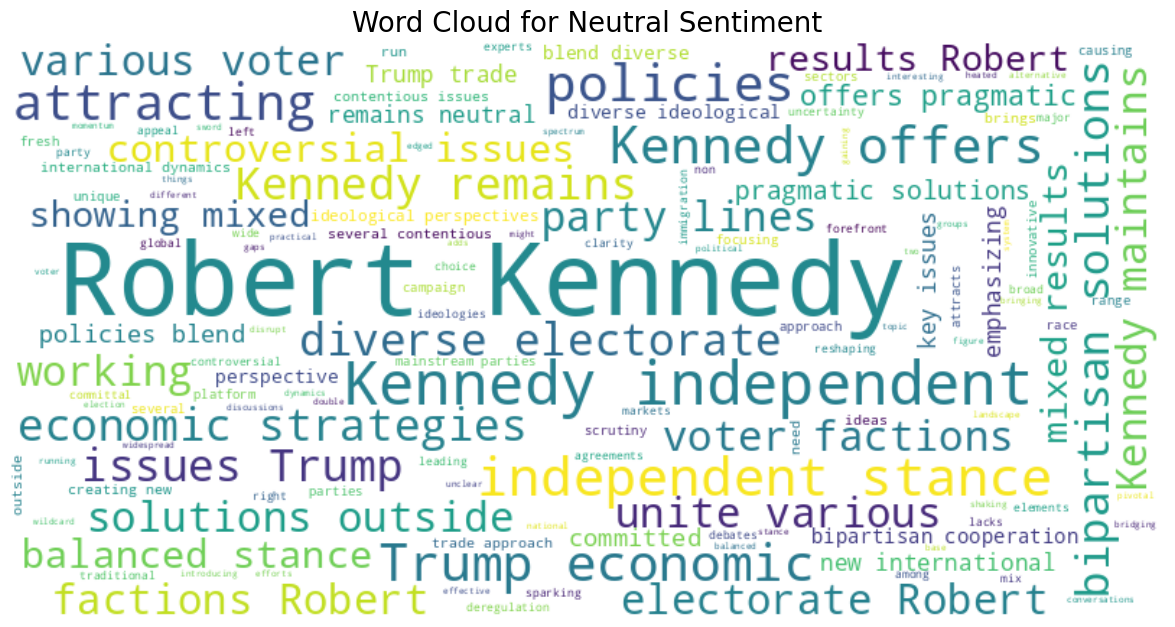

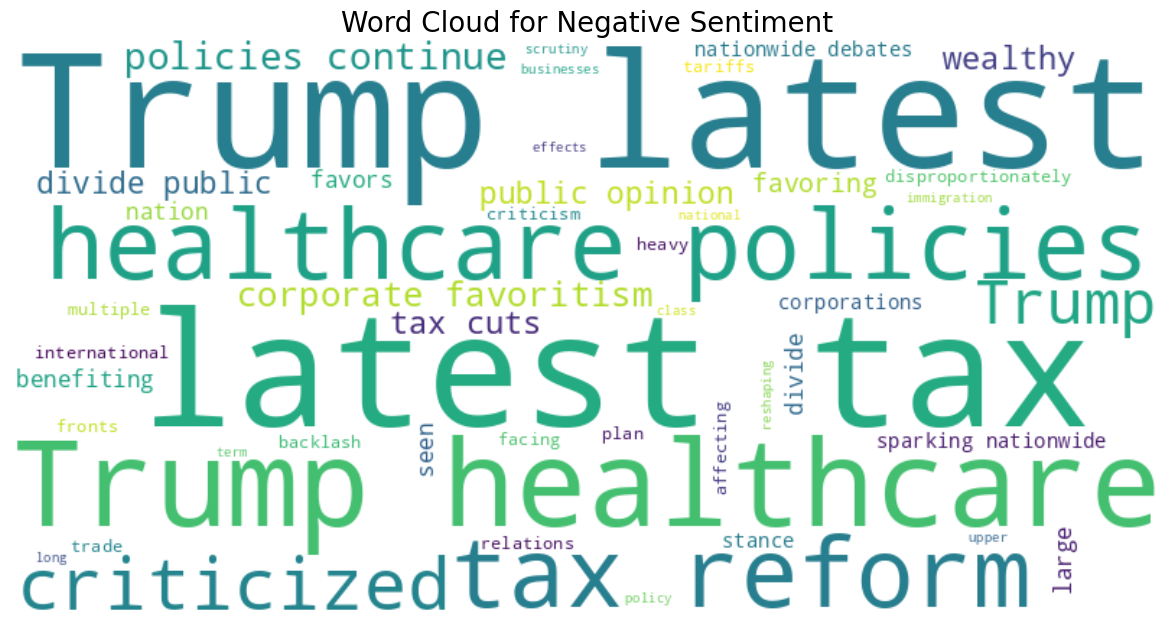

In [ ]:
# Generate word clouds for each sentiment
for sentiment in ['Positive', 'Neutral', 'Negative']:
    subset = train[train['sentiment'] == sentiment]
    generate_wordcloud(subset['tweet_text'], f'Word Cloud for {sentiment.capitalize()} Sentiment')

## Data Preprocessing

### Text Cleaning

In [ ]:
# Combine all datasets for preprocessing
data = pd.concat([train.reset_index(), test.reset_index(), val.reset_index()], ignore_index=True)

In [ ]:
data.head()

,timestamp,tweet_id,user_handle,tweet_text,candidate,party,retweets,likes,sentiment,tweet_length,index
0,2024-11-03 08:45:00,1,@user123,Excited to see Kamala Harris leading the Democ...,Kamala Harris,Democratic Party,120,450,Positive,9,NaN
1,2024-11-03 09:15:23,2,@politicsFan,Donald Trump's policies are the best for our e...,Donald Trump,Republican Party,85,300,Positive,9,NaN
2,2024-11-03 10:05:45,3,@greenAdvocate,Jill Stein's environmental plans are exactly w...,Jill Stein,Green Party,60,200,Positive,9,NaN
3,2024-11-03 11:20:10,4,@indieVoice,Robert Kennedy offers a fresh perspective outs...,Robert Kennedy,Independent,40,150,Neutral,10,NaN
4,2024-11-03 12:35:55,5,@libertyLover,Chase Oliver's libertarian stance promotes tru...,Chase Oliver,Libertarian Party,30,120,Positive,7,NaN


In [ ]:
# Function to clean tweet text
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    return text

In [ ]:
# Apply cleaning
data['clean_text'] = data['tweet_text'].apply(clean_text)

In [ ]:
data.head()

,timestamp,tweet_id,user_handle,tweet_text,candidate,party,retweets,likes,sentiment,tweet_length,index,clean_text
0,2024-11-03 08:45:00,1,@user123,Excited to see Kamala Harris leading the Democ...,Kamala Harris,Democratic Party,120,450,Positive,9,NaN,excited to see kamala harris leading the democ...
1,2024-11-03 09:15:23,2,@politicsFan,Donald Trump's policies are the best for our e...,Donald Trump,Republican Party,85,300,Positive,9,NaN,donald trumps policies are the best for our ec...
2,2024-11-03 10:05:45,3,@greenAdvocate,Jill Stein's environmental plans are exactly w...,Jill Stein,Green Party,60,200,Positive,9,NaN,jill steins environmental plans are exactly wh...
3,2024-11-03 11:20:10,4,@indieVoice,Robert Kennedy offers a fresh perspective outs...,Robert Kennedy,Independent,40,150,Neutral,10,NaN,robert kennedy offers a fresh perspective outs...
4,2024-11-03 12:35:55,5,@libertyLover,Chase Oliver's libertarian stance promotes tru...,Chase Oliver,Libertarian Party,30,120,Positive,7,NaN,chase olivers libertarian stance promotes true...


In [ ]:
# Display cleaned text
data[['tweet_text', 'clean_text']].head()

,tweet_text,clean_text
0,Excited to see Kamala Harris leading the Democ...,excited to see kamala harris leading the democ...
1,Donald Trump's policies are the best for our e...,donald trumps policies are the best for our ec...
2,Jill Stein's environmental plans are exactly w...,jill steins environmental plans are exactly wh...
3,Robert Kennedy offers a fresh perspective outs...,robert kennedy offers a fresh perspective outs...
4,Chase Oliver's libertarian stance promotes tru...,chase olivers libertarian stance promotes true...


### Handling Missing Values

In [ ]:
# check for missing values
data.isnull().sum()

,0
timestamp,0
tweet_id,0
user_handle,0
tweet_text,0
candidate,0
party,0
retweets,0
likes,0
sentiment,0
tweet_length,0


### Encoding Categorical Variables

In [ ]:
# importing label encoder liberary
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Encode 'party' using Label Encoding
le_party = LabelEncoder()
data['party_encoded'] = le_party.fit_transform(data['party'])

In [ ]:
# Map sentiment to numerical values for evaluation
sentiment_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
data['sentiment_encoded'] = data['sentiment'].map(sentiment_mapping)

In [ ]:
data

,timestamp,tweet_id,user_handle,tweet_text,candidate,party,retweets,likes,sentiment,tweet_length,index,clean_text,party_encoded,sentiment_encoded
0,2024-11-03 08:45:00,1,@user123,Excited to see Kamala Harris leading the Democ...,Kamala Harris,Democratic Party,120,450,Positive,9,NaN,excited to see kamala harris leading the democ...,0,2.0
1,2024-11-03 09:15:23,2,@politicsFan,Donald Trump's policies are the best for our e...,Donald Trump,Republican Party,85,300,Positive,9,NaN,donald trumps policies are the best for our ec...,4,2.0
2,2024-11-03 10:05:45,3,@greenAdvocate,Jill Stein's environmental plans are exactly w...,Jill Stein,Green Party,60,200,Positive,9,NaN,jill steins environmental plans are exactly wh...,1,2.0
3,2024-11-03 11:20:10,4,@indieVoice,Robert Kennedy offers a fresh perspective outs...,Robert Kennedy,Independent,40,150,Neutral,10,NaN,robert kennedy offers a fresh perspective outs...,2,1.0
4,2024-11-03 12:35:55,5,@libertyLover,Chase Oliver's libertarian stance promotes tru...,Chase Oliver,Libertarian Party,30,120,Positive,7,NaN,chase olivers libertarian stance promotes true...,3,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2025-03-02 08:50:30,596,@user1085,Kamala Harris is a symbol of progressive leade...,Kamala Harris,Democratic Party,95,360,Positive,8,45.0,kamala harris is a symbol of progressive leade...,0,2.0
596,2025-03-02 09:15:55,597,@econTalk8,Trump's economic strategies are showing mixed ...,Donald Trump,Republican Party,100,440,Neutral,7,46.0,trumps economic strategies are showing mixed r...,4,1.0
597,2025-03-02 10:05:30,598,@greenFutureNow8,Jill Stein's solar projects are leading the wa...,Jill Stein,Green Party,75,240,Positive,11,47.0,jill steins solar projects are leading the way...,1,2.0
598,2025-03-02 11:35:25,599,@indiePerspective8,Robert Kennedy offers pragmatic solutions outs...,Robert Kennedy,Independent,18,85,Neutral,9,48.0,robert kennedy offers pragmatic solutions outs...,2,1.0


In [ ]:
data.isnull().sum()

,0
timestamp,0
tweet_id,0
user_handle,0
tweet_text,0
candidate,0
party,0
retweets,0
likes,0
sentiment,0
tweet_length,0


In [ ]:
# drop missing values from sentiment_encoded column
data.dropna(subset=['sentiment_encoded'], inplace=True)

In [ ]:
data.isnull().sum()

,0
timestamp,0
tweet_id,0
user_handle,0
tweet_text,0
candidate,0
party,0
retweets,0
likes,0
sentiment,0
tweet_length,0


In [ ]:
data['sentiment'].value_counts()

,count
sentiment,
Positive,396
Neutral,152
Negative,51


In [ ]:
# Split back into train, test, val
train = data.iloc[:500].copy()
test = data.iloc[500:550].copy()
val = data.iloc[550:600].copy()

In [ ]:
# Display encoded features
train[['party', 'party_encoded', 'sentiment', 'sentiment_encoded']].head()

,party,party_encoded,sentiment,sentiment_encoded
0,Democratic Party,0,Positive,2.0
1,Republican Party,4,Positive,2.0
2,Green Party,1,Positive,2.0
3,Independent,2,Neutral,1.0
4,Libertarian Party,3,Positive,2.0


## LLM-Based Sentiment Analysis

### Model Selection

For this analysis, we utilize Hugging Face's `transformers` library, specifically the `pipeline` API, which provides a simple interface for various NLP tasks. We employ the `distilbert-base-uncased-finetuned-sst-2-english` model, a distilled version of BERT fine-tuned on the SST-2 dataset for sentiment analysis. This model is efficient and suitable for our classification task.

In [ ]:
# Initialize sentiment analysis pipeline with a pre-trained model
sentiment_pipeline = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

# Test the pipeline on a sample tweet
sample_tweet = train['tweet_text'].iloc[0]
print('Sample Tweet:', sample_tweet)
print('Sentiment Analysis Result:', sentiment_pipeline(sample_tweet))

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Sample Tweet: Excited to see Kamala Harris leading the Democratic charge!
Sentiment Analysis Result: [{'label': 'POSITIVE', 'score': 0.9997492432594299}]


### Inference with Pre-trained Models

In [ ]:
# Function to perform sentiment analysis using the pipeline
def analyze_sentiment(text):
    try:
        result = sentiment_pipeline(text[:512])[0]  # Truncate to 512 tokens
        return result['label'], result['score']
    except Exception as e:
        return 'ERROR', 0

# Apply sentiment analysis to training set
train[['predicted_sentiment', 'confidence']] = train['tweet_text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Apply sentiment analysis to validation set
val[['predicted_sentiment', 'confidence']] = val['tweet_text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Apply sentiment analysis to test set
test[['predicted_sentiment', 'confidence']] = test['tweet_text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

# Display results
train[['tweet_text', 'predicted_sentiment', 'confidence']].head()

,tweet_text,predicted_sentiment,confidence
0,Excited to see Kamala Harris leading the Democ...,POSITIVE,0.999749
1,Donald Trump's policies are the best for our e...,POSITIVE,0.999732
2,Jill Stein's environmental plans are exactly w...,POSITIVE,0.999530
3,Robert Kennedy offers a fresh perspective outs...,POSITIVE,0.999691
4,Chase Oliver's libertarian stance promotes tru...,POSITIVE,0.998540


## Evaluation

### Performance Metrics

In [ ]:
val['predicted_sentiment'] = val['tweet_text'].apply(lambda x: analyze_sentiment(x)[0])

# Convert predicted sentiment to lowercase
val['predicted_sentiment'] = val['predicted_sentiment'].str.lower()

# Convert to categorical AFTER converting to lowercase AND adding the category
val['predicted_sentiment'] = pd.Categorical(val['predicted_sentiment'], categories=['Negative', 'Neutral', 'Positive'])

In [ ]:
# Check for missing predicted sentiments and handle them (using the new approach)
if val['predicted_sentiment'].isnull().any():
    print("Warning: Missing predicted sentiments found. Filling with 'NEUTRAL'.")
    val['predicted_sentiment'] = val['predicted_sentiment'].fillna('Neutral')


In [ ]:
# Print unique values to verify
print("Unique values in val['sentiment']:", val['sentiment'].unique())
print("Unique values in val['predicted_sentiment']:", val['predicted_sentiment'].unique())


Unique values in val['sentiment']: ['Positive' 'Neutral' 'Negative']
Unique values in val['predicted_sentiment']: ['Neutral']
Categories (3, object): ['Negative', 'Neutral', 'Positive']


In [ ]:
# Generate classification report
print(classification_report(val['sentiment'], val['predicted_sentiment'], target_names=['Negative', 'Neutral', 'Positive'])) #Explicitly stating categories here

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00         3
     Neutral       0.27      1.00      0.42        13
    Positive       0.00      0.00      0.00        33

    accuracy                           0.27        49
   macro avg       0.09      0.33      0.14        49
weighted avg       0.07      0.27      0.11        49



### Insights
- **Negative Class**: The model failed entirely to predict any instances of the Negative class (precision, recall, and F1-score are all 0.00). This suggests significant difficulty in identifying Negative sentiments.
- **Neutral Class**: The model performs best here, achieving perfect recall (1.00), indicating all Neutral instances were identified. However, precision is low (0.27), meaning there were many false positives.
- **Positive Class**: Similar to the Negative class, no instances of Positive sentiment were identified correctly (precision, recall, and F1-score are 0.00).
- **Overall Accuracy**: At 27%, the model’s overall performance is poor, failing to generalize well across all classes.
- **Class Imbalance**: The dataset exhibits significant imbalance, with 33 Positive instances, 13 Neutral, and only 3 Negative. This likely contributes to poor performance in the minority classes.



### Observations and Suggestions
- **Address Data Imbalance**:
  - Oversample Negative instances or undersample Positive instances.
  - Use techniques like SMOTE to generate synthetic samples for minority classes.
- **Improve Feature Representation**:
  - Extract domain-specific features that capture sentiment more effectively.
  - Leverage pre-trained embeddings like Word2Vec or BERT for richer representation.
- **Try Alternative Models**:
  - Experiment with ensemble methods (e.g., Random Forest, Gradient Boosting).
  - Evaluate deep learning architectures if sufficient data is available.
- **Adjust Class Weights**:
  - Penalize misclassification of minority classes by assigning higher weights to Negative and Positive classes during training.
- **Hyperparameter Tuning**:
  - Optimize model settings to achieve better trade-offs between precision and recall.
- **Evaluate Thresholds**:
  - Adjust classification thresholds to improve precision without sacrificing recall excessively.


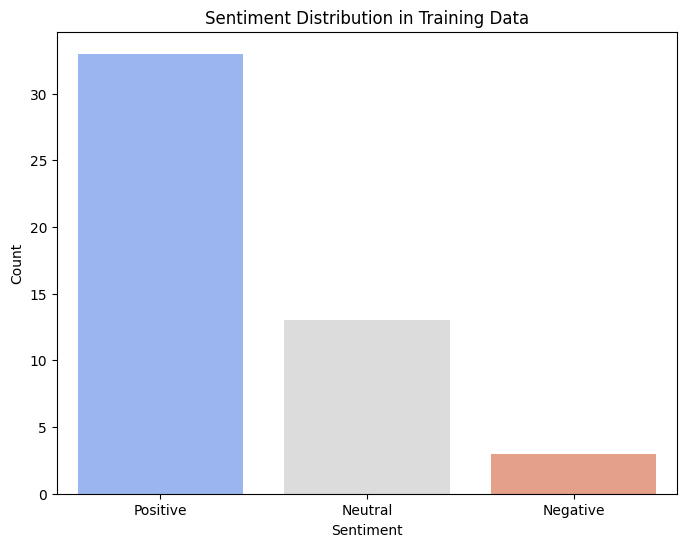

In [ ]:
# Sentiment distribution in val data
plt.figure(figsize=(8,6))
sns.countplot(x='sentiment', data=val, palette='coolwarm')
plt.title('Sentiment Distribution in Training Data')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

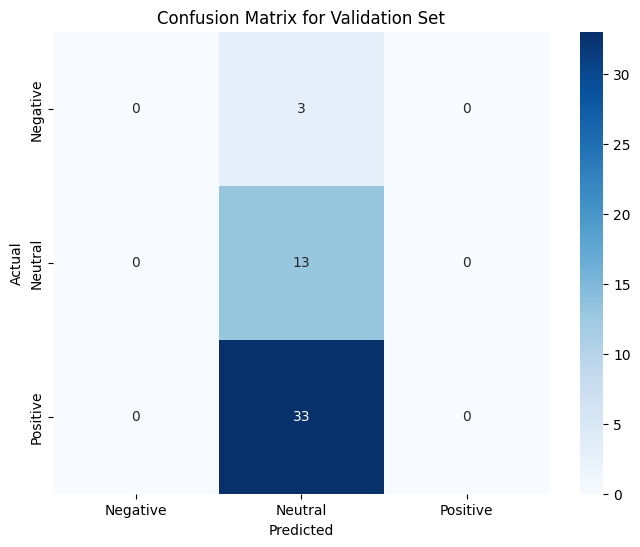

In [ ]:
# Generate confusion matrix using lowercase labels
cm = confusion_matrix(val['sentiment'], val['predicted_sentiment'], labels=['Negative', 'Neutral', 'Positive'])  # Use lowercase labels

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])  # Lowercase labels for ticks
plt.title('Confusion Matrix for Validation Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

From the above charts we can say that the model seems baised and was unable to classify positive and negative sentiments.

This could be because the distribution of sentiment category is not even distributed